# Regional-k-means

**Authors:** **[Sergio Rey](https://github.com/sjsrey),** **[Xin Feng](https://github.com/xf37),** **[James Gaboardi](https://github.com/jGaboardi)**

Regional-k-means is K-means with the constraint that each cluster forms a spatially connected component. The algorithm is developed by [Sergio Rey](https://github.com/sjsrey). This tutorial goes through the following:


1. a small synthetic example (10x10 lattice)
2. a large synthetic example (50x50 lattice)
3. an empirical example (Rio Grande do Sul, Brasil)

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2022-10-18T08:36:45.840715-04:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import libpysal
import numpy
import spopt
from spopt.region import RegionKMeansHeuristic

%matplotlib inline
%watermark -w
%watermark -iv

Watermark: 2.3.1

json     : 2.0.9
numpy    : 1.23.3
geopandas: 0.11.1
libpysal : 4.6.2
spopt    : 0.4.1+200.g336f235.dirty



------------------------------------------------

## 1. Small synthetic example

### Create synthetic data

Create a [spatial weights object](https://pysal.org/libpysal/tutorial.html) for a 10*10 regular lattice. 

In [3]:
dim = 10
w = libpysal.weights.lat2W(dim, dim)
w.n

100

Draw 100 random samples (the given shape is (100, 3)) from a normal (Gaussian) distribution. Then, there are three values for each lattice. They are variables in the dataframe that will be used to measure regional homogeneity.

In [4]:
RANDOM_SEED = 12345
numpy.random.seed(RANDOM_SEED)
data = numpy.random.normal(size=(w.n, 3))
data

array([[-2.04707659e-01,  4.78943338e-01, -5.19438715e-01],
       [-5.55730304e-01,  1.96578057e+00,  1.39340583e+00],
       [ 9.29078767e-02,  2.81746153e-01,  7.69022568e-01],
       [ 1.24643474e+00,  1.00718936e+00, -1.29622111e+00],
       [ 2.74991633e-01,  2.28912879e-01,  1.35291684e+00],
       [ 8.86429341e-01, -2.00163731e+00, -3.71842537e-01],
       [ 1.66902531e+00, -4.38569736e-01, -5.39741446e-01],
       [ 4.76985010e-01,  3.24894392e+00, -1.02122752e+00],
       [-5.77087303e-01,  1.24121276e-01,  3.02613562e-01],
       [ 5.23772068e-01,  9.40277775e-04,  1.34380979e+00],
       [-7.13543985e-01, -8.31153539e-01, -2.37023165e+00],
       [-1.86076079e+00, -8.60757398e-01,  5.60145293e-01],
       [-1.26593449e+00,  1.19827125e-01, -1.06351245e+00],
       [ 3.32882716e-01, -2.35941881e+00, -1.99542955e-01],
       [-1.54199553e+00, -9.70735912e-01, -1.30703025e+00],
       [ 2.86349747e-01,  3.77984111e-01, -7.53886535e-01],
       [ 3.31285650e-01,  1.34974221e+00

The neighbors of each lattice can be checked by:

In [5]:
w.neighbors

{0: [10, 1],
 10: [0, 20, 11],
 1: [0, 11, 2],
 11: [1, 10, 21, 12],
 2: [1, 12, 3],
 12: [2, 11, 22, 13],
 3: [2, 13, 4],
 13: [3, 12, 23, 14],
 4: [3, 14, 5],
 14: [4, 13, 24, 15],
 5: [4, 15, 6],
 15: [5, 14, 25, 16],
 6: [5, 16, 7],
 16: [6, 15, 26, 17],
 7: [6, 17, 8],
 17: [7, 16, 27, 18],
 8: [7, 18, 9],
 18: [8, 17, 28, 19],
 9: [8, 19],
 19: [9, 18, 29],
 20: [10, 30, 21],
 21: [11, 20, 31, 22],
 22: [12, 21, 32, 23],
 23: [13, 22, 33, 24],
 24: [14, 23, 34, 25],
 25: [15, 24, 35, 26],
 26: [16, 25, 36, 27],
 27: [17, 26, 37, 28],
 28: [18, 27, 38, 29],
 29: [19, 28, 39],
 30: [20, 40, 31],
 31: [21, 30, 41, 32],
 32: [22, 31, 42, 33],
 33: [23, 32, 43, 34],
 34: [24, 33, 44, 35],
 35: [25, 34, 45, 36],
 36: [26, 35, 46, 37],
 37: [27, 36, 47, 38],
 38: [28, 37, 48, 39],
 39: [29, 38, 49],
 40: [30, 50, 41],
 41: [31, 40, 51, 42],
 42: [32, 41, 52, 43],
 43: [33, 42, 53, 44],
 44: [34, 43, 54, 45],
 45: [35, 44, 55, 46],
 46: [36, 45, 56, 47],
 47: [37, 46, 57, 48],
 48: [38, 

We first explore the simulated data by building a 10*10 lattice shapefile.

In [6]:
libpysal.weights.build_lattice_shapefile(dim, dim, "lattice.shp")

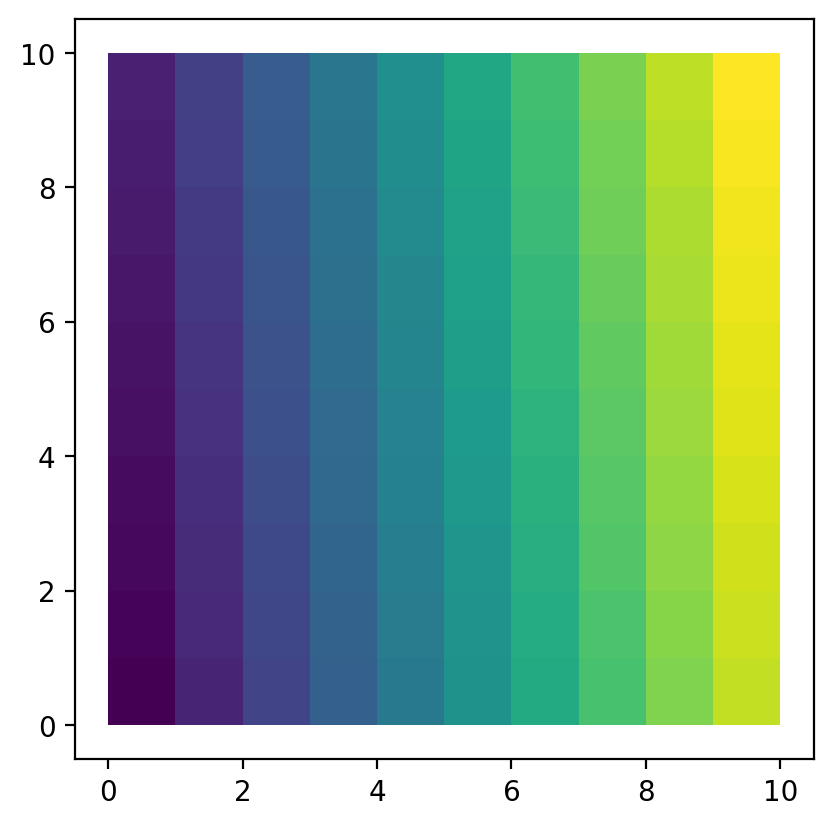

In [7]:
gdf = geopandas.read_file("lattice.shp")
gdf.plot(column="ID");

### Regionalization

With `reg-k-means`, we aggregate 100 simulated lattices into 20 regions.

The model can then be solved:

In [8]:
model = RegionKMeansHeuristic(data, 20, w)
model.solve()

In [9]:
model.labels_

array([12,  3,  3,  3,  3,  3, 19, 19, 17, 11, 12,  9,  9,  7,  7,  2,  2,
        2, 17, 11, 12, 15,  9,  7, 18,  2, 13, 13,  6,  6, 15, 15,  9, 18,
       18,  2, 13, 13,  0,  6, 15,  1,  1, 18, 18, 13, 13, 13,  0,  6,  1,
        1,  4,  4, 18, 18,  0,  0,  0,  0,  1, 16,  4,  4,  4, 10, 10, 14,
        5,  5, 16, 16, 16,  4,  8, 10, 10, 14,  5,  5, 16,  8, 16,  8,  8,
       10, 10, 14,  5, 14,  8,  8,  8,  8,  8, 10, 10, 14, 14, 14])

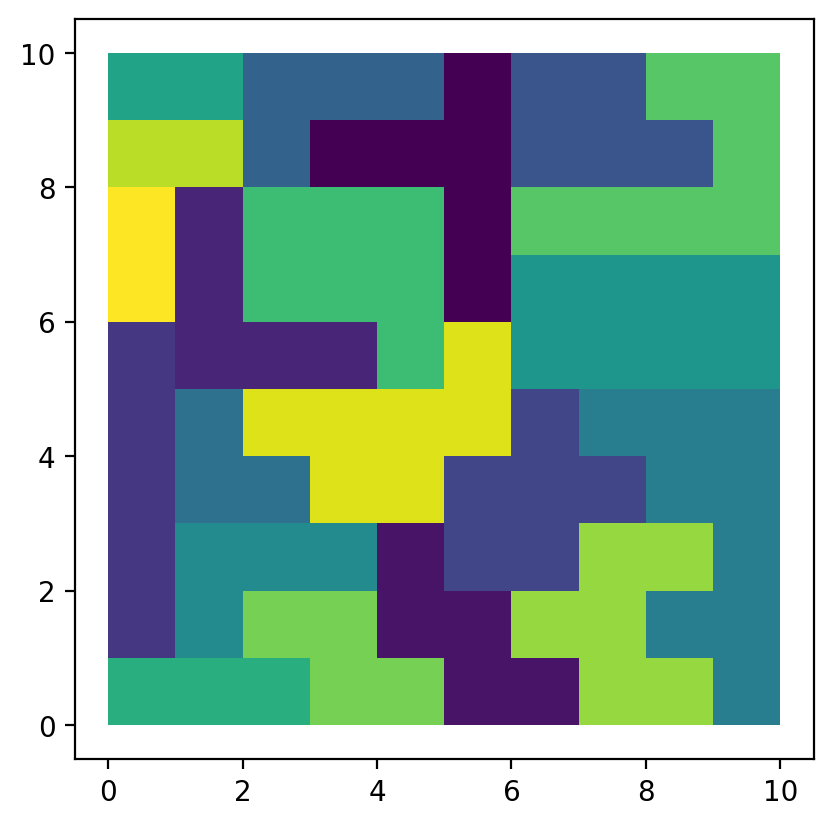

In [10]:
gdf["region"] = model.labels_
gdf.plot(column="region");

The model solution results in 20 spatially connected regions. We can summarize which lattice belongs to which region:

In [11]:
areas = numpy.arange(dim * dim)
regions = [areas[model.labels_ == region] for region in range(20)]
regions

[array([38, 48, 56, 57, 58, 59]),
 array([41, 42, 50, 51, 60]),
 array([15, 16, 17, 25, 35]),
 array([1, 2, 3, 4, 5]),
 array([52, 53, 62, 63, 64, 73]),
 array([68, 69, 78, 79, 88]),
 array([28, 29, 39, 49]),
 array([13, 14, 23]),
 array([74, 81, 83, 84, 90, 91, 92, 93, 94]),
 array([11, 12, 22, 32]),
 array([65, 66, 75, 76, 85, 86, 95, 96]),
 array([ 9, 19]),
 array([ 0, 10, 20]),
 array([26, 27, 36, 37, 45, 46, 47]),
 array([67, 77, 87, 89, 97, 98, 99]),
 array([21, 30, 31, 40]),
 array([61, 70, 71, 72, 80, 82]),
 array([ 8, 18]),
 array([24, 33, 34, 43, 44, 54, 55]),
 array([6, 7])]

------------------------------------------------

## 2. Large synthetic example

### Create synthetic data

Generate a 50 x 50 lattice with `spenc`

In [12]:
from spopt.region.spenclib.utils import lattice

hori, vert = 50, 50
n_polys = hori * vert
gdf = lattice(hori, vert)
gdf.head()

,geometry
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1...."
1,"POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1...."
2,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 1...."
3,"POLYGON ((0.00000 3.00000, 1.00000 3.00000, 1...."
4,"POLYGON ((0.00000 4.00000, 1.00000 4.00000, 1...."


Generate some random attribute data values

In [13]:
numpy.random.seed(RANDOM_SEED)
gdf["data_values_1"] = numpy.random.random(n_polys)
gdf["data_values_2"] = numpy.random.random(n_polys)
vals = ["data_values_1", "data_values_2"]
gdf.head()

,geometry,data_values_1,data_values_2
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....",0.929616,0.510240
1,"POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1....",0.316376,0.483683
2,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 1....",0.183919,0.686935
3,"POLYGON ((0.00000 3.00000, 1.00000 3.00000, 1....",0.204560,0.441431
4,"POLYGON ((0.00000 4.00000, 1.00000 4.00000, 1....",0.567725,0.242545


Split into 2 artifical islands

In [14]:
gdf = gdf[:1300].append(gdf[1500:])
w = libpysal.weights.Rook.from_dataframe(gdf)

/var/folders/71/bk36jbtj26n_v5fhw9tnzzl00000gn/T/ipykernel_32955/1520827570.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf[:1300].append(gdf[1500:])
/Users/the-gaboardi/miniconda3/envs/py310_spopt/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


### Regionalization

Partition into 8 regions

In [15]:
numpy.random.seed(RANDOM_SEED)
model = RegionKMeansHeuristic(gdf[vals].values, 8, w)
model.solve()

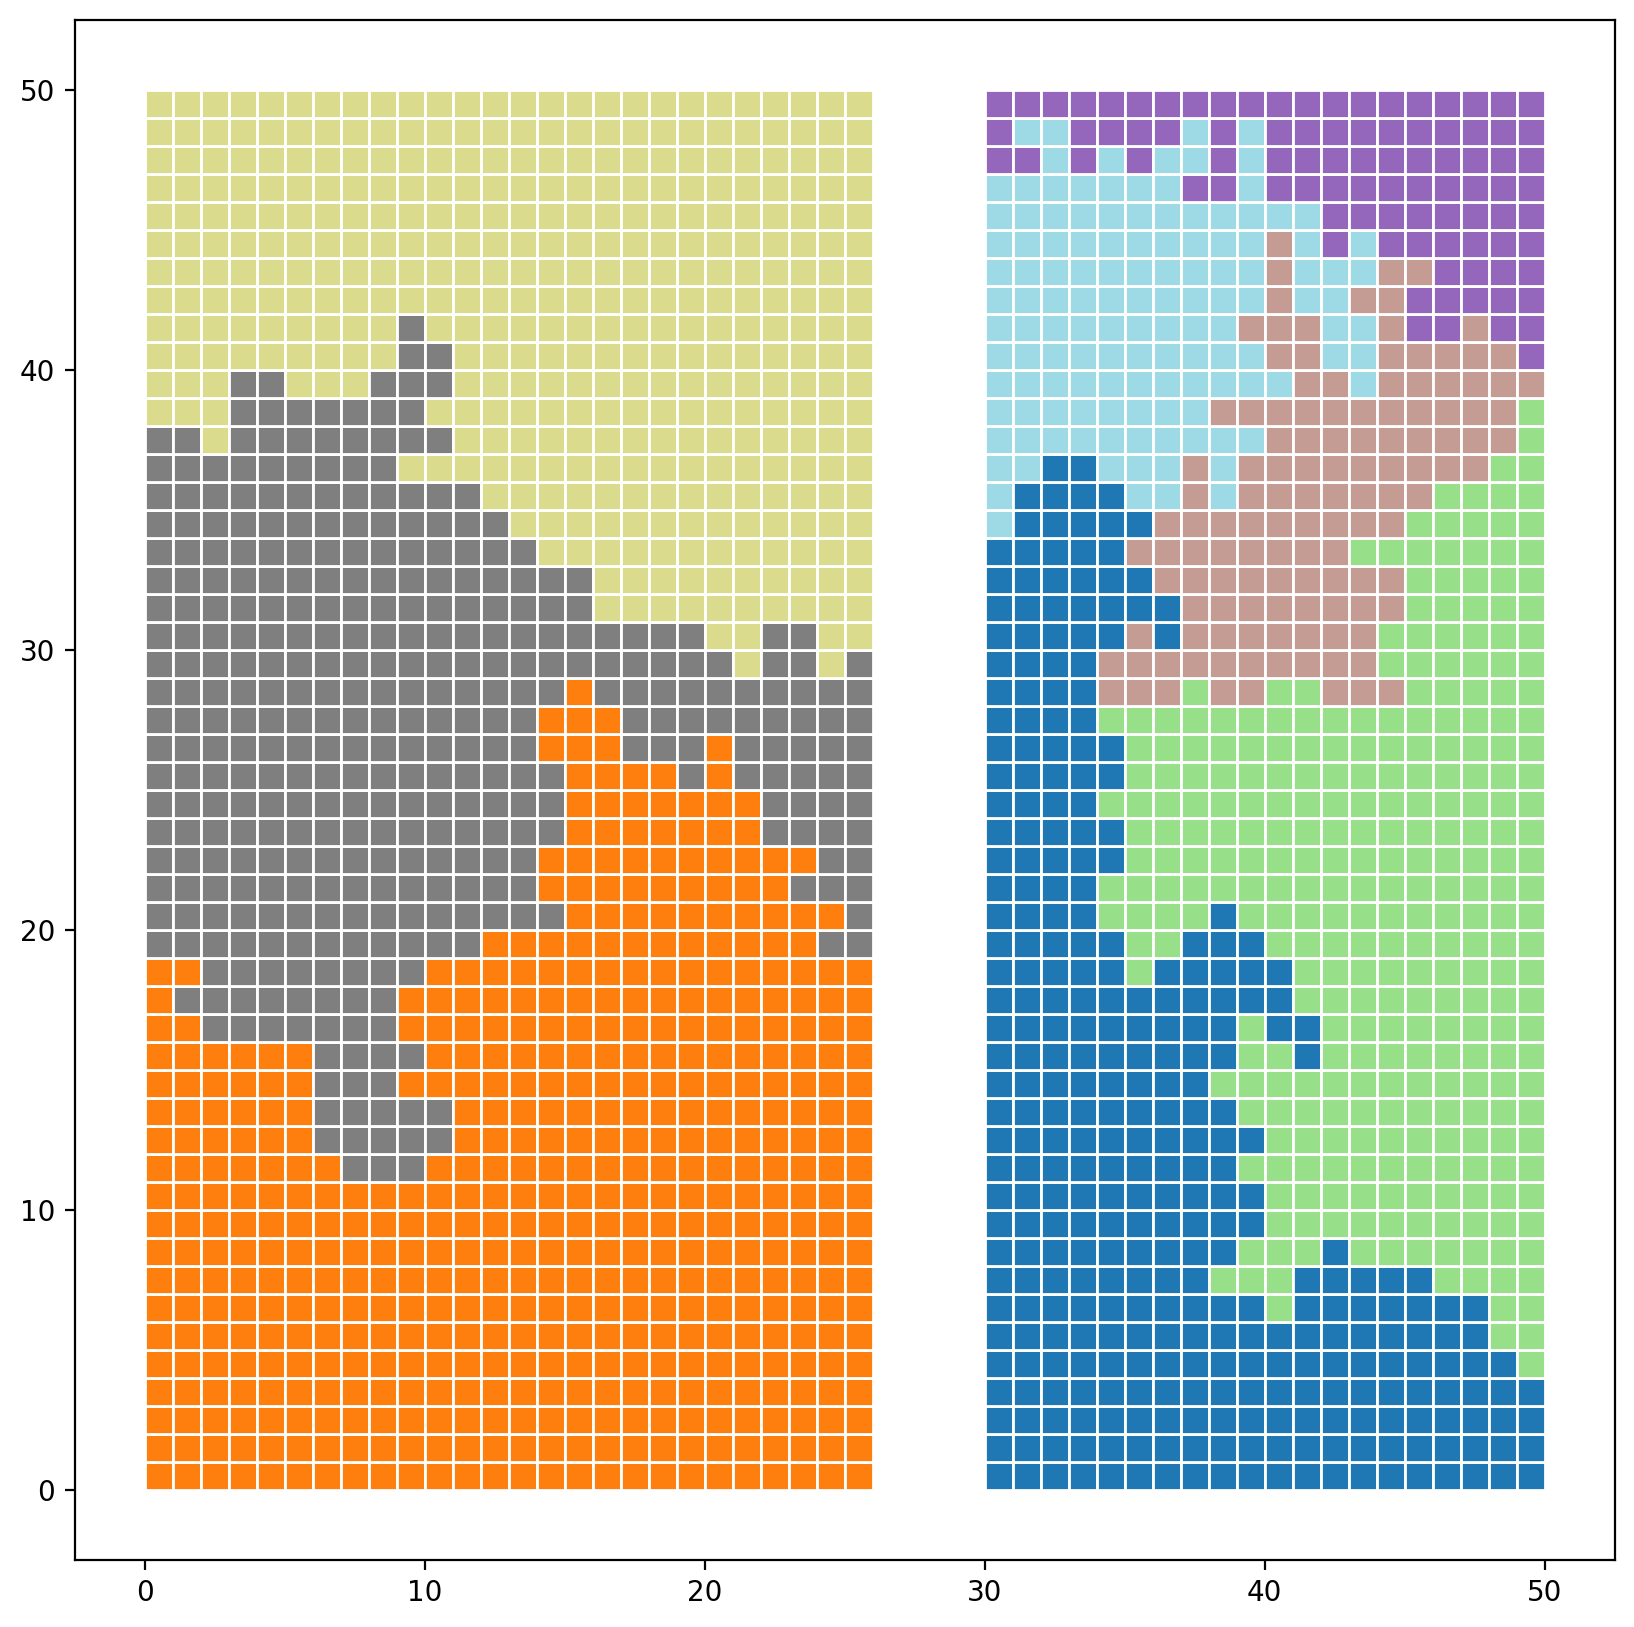

In [16]:
gdf["reg_k_mean"] = model.labels_
gdf.plot(
    column="reg_k_mean", categorical=True, cmap="tab20", figsize=(10, 10), edgecolor="w"
);

------------------------------------------------

## 3. Empirical example (empircal geographies & synthetic atttributes)

Read in Rio Grande do Sul, Brasil dataset

In [17]:
libpysal.examples.load_example("Rio Grande do Sul")

Example not available: Rio Grande do Sul
Example not downloaded: Chicago parcels
Example not downloaded: Chile Migration
Example not downloaded: Spirals


In [18]:
rsbr = libpysal.examples.get_path("map_RS_BR.shp")
rsbr_gdf = geopandas.read_file(rsbr)
rsbr_gdf.head()

,NM_MUNICIP,CD_GEOCMU,geometry
0,ACEGUÁ,4300034,"POLYGON ((-54.10940 -31.43316, -54.10889 -31.4..."
1,ÁGUA SANTA,4300059,"POLYGON ((-51.98932 -28.12943, -51.98901 -28.1..."
2,AGUDO,4300109,"POLYGON ((-53.13696 -29.49483, -53.13481 -29.4..."
3,AJURICABA,4300208,"POLYGON ((-53.61993 -28.14569, -53.62100 -28.1..."
4,ALECRIM,4300307,"POLYGON ((-54.77813 -27.58372, -54.77307 -27.5..."


Generate some random attribute data values

In [19]:
n_polys = rsbr_gdf.shape[0]
numpy.random.seed(RANDOM_SEED)
attr_cols = ["attr_1", "attr_2", "attr_3", "attr_4"]
for attr_col in attr_cols:
    rsbr_gdf[attr_col] = numpy.random.random(n_polys)
rsbr_gdf.head()

,NM_MUNICIP,CD_GEOCMU,geometry,attr_1,attr_2,attr_3,attr_4
0,ACEGUÁ,4300034,"POLYGON ((-54.10940 -31.43316, -54.10889 -31.4...",0.929616,0.990111,0.978448,0.194226
1,ÁGUA SANTA,4300059,"POLYGON ((-51.98932 -28.12943, -51.98901 -28.1...",0.316376,0.126155,0.004249,0.245969
2,AGUDO,4300109,"POLYGON ((-53.13696 -29.49483, -53.13481 -29.4...",0.183919,0.976601,0.559856,0.018801
3,AJURICABA,4300208,"POLYGON ((-53.61993 -28.14569, -53.62100 -28.1...",0.204560,0.229106,0.751780,0.427996
4,ALECRIM,4300307,"POLYGON ((-54.77813 -27.58372, -54.77307 -27.5...",0.567725,0.186056,0.390045,0.179598


Enforce fuzzy contiguity due to [nonplanar-geometries](https://pysal.org/libpysal/notebooks/weights.html#Handling-nonplanar-geometries)

In [20]:
rsbr_w = libpysal.weights.fuzzy_contiguity(rsbr_gdf)

Partition into 2 regions

In [21]:
numpy.random.seed(RANDOM_SEED)
model = RegionKMeansHeuristic(rsbr_gdf[attr_cols].values, 2, rsbr_w)
model.solve()

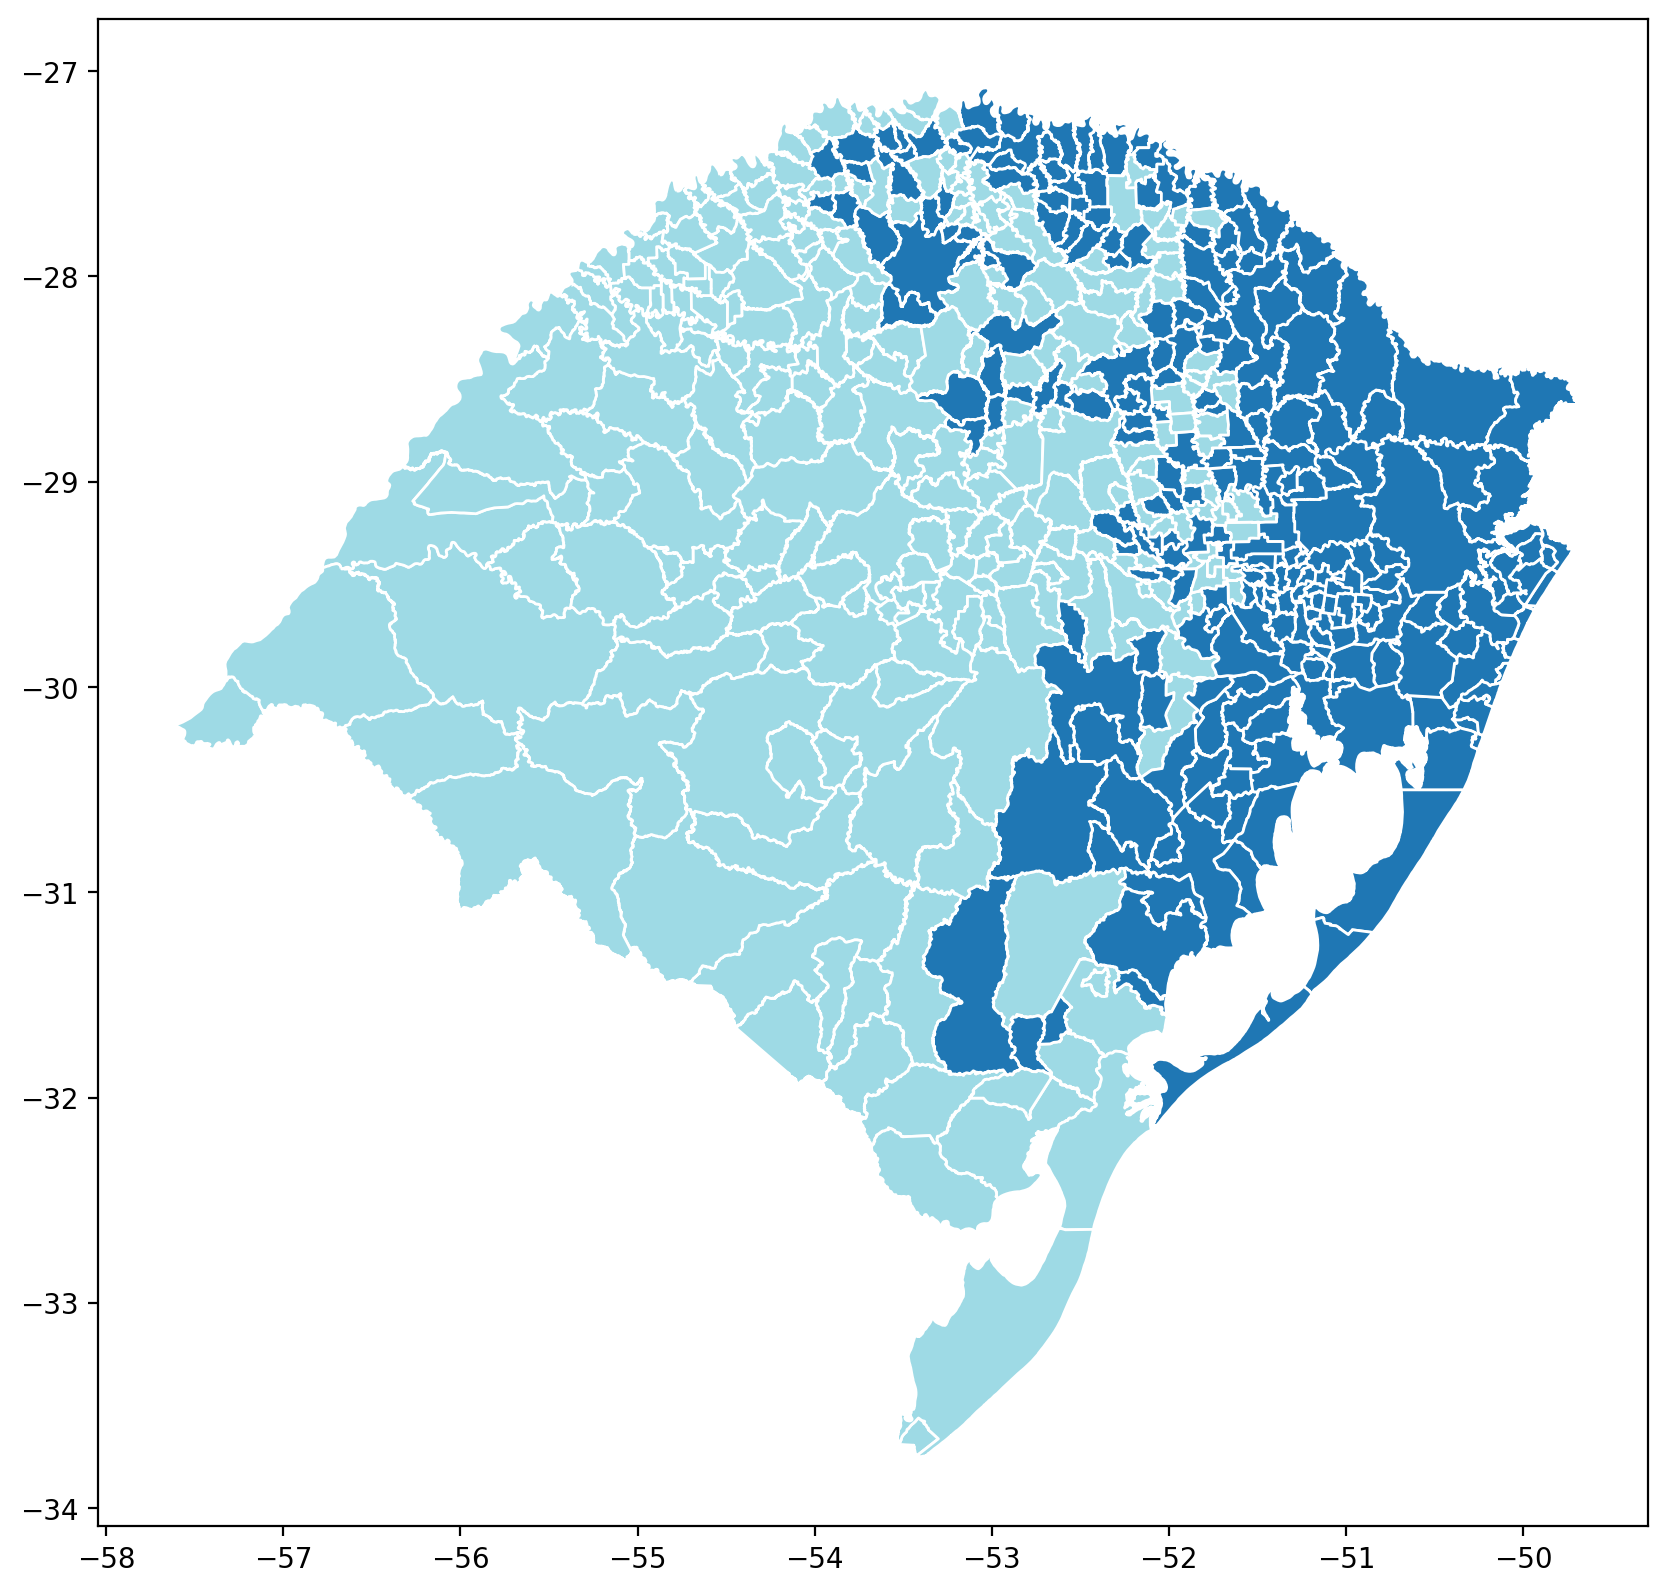

In [22]:
rsbr_gdf["reg_k_mean"] = model.labels_
rsbr_gdf.plot(
    column="reg_k_mean", categorical=True, cmap="tab20", figsize=(10, 10), edgecolor="w"
);

-----------------